In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Cleaning
## 1. Data filtering
- Filter out campaigns whose state is "live" or "canceled"
- Eliminate rows with null values in description, which may caused by different html structure when scraping

## 2. Check data balance
- Group campaigns by their state and check the balance of two groups

In [4]:
# data cleaning
#df_raw = pd.read_csv("C:/Users/Administrator/Kickstarter/filtered.csv")
# select successful and failed projects
#df = df_raw[df_raw.state.isin(['successful', 'failed'])]
# eliminate rows with null values in description
#df = df[df['descripton'].isnull()!= True]
#df.shape
#df.to_csv("C:/Users/Administrator/Kickstarter/data.csv", index = False)
df = pd.read_csv("C:/Users/Administrator/Kickstarter/data.csv")
df.shape
df.groupby('state').size()

(52651, 47)

state
failed        20158
successful    32493
dtype: int64

## 3. Extract category and location information from a composed column

In [3]:
# extract category information
import re
import math
df.loc[0:5, 'category and location']
cate = df.loc[0, 'category and location']
cate
re.findall('(\w+) ', cate)
cate_loc = df.loc[:, 'category and location']
cate_notnull = []
def isnan(value):
    try:
        return math.isnan(float(value))
    except:
        return False
for string in cate_loc:
    if isnan(string) != True:
        cate_notnull.append(string)
len(cate_loc)
len(cate_notnull)
for string in cate_notnull:
    tokens = string.split(' ')
tokens[0]
#df_cate.groupby('state').size()

0             Journalism Denver, CO
1           Journalism Richmond, VA
2    Illustration West Columbia, SC
3        Illustration Sheffield, UK
4        Illustration St. Louis, MO
5                  Apparel Bend, OR
Name: category and location, dtype: object

'Journalism Denver, CO'

['Journalism']

52651

20156

'Journalism'

# EDA
- Logarize non-textual features
- Variable distributions and data scatter plot
- Plot correlation matrix
- Investigate number of campaigns in different funded ranges
- Barplot for different funded ranges

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


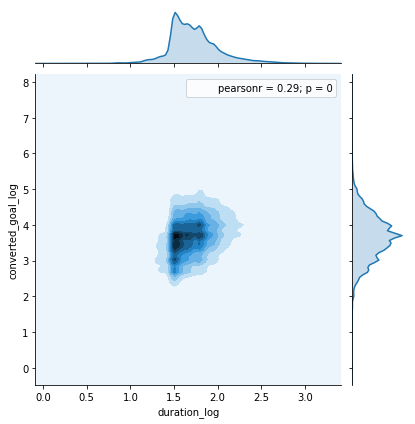

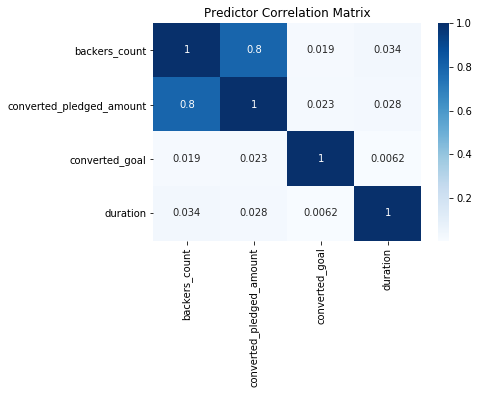

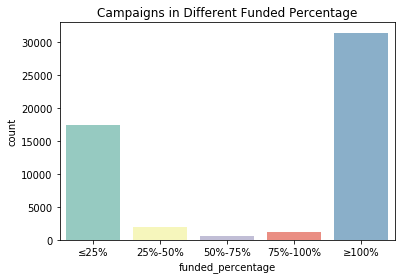

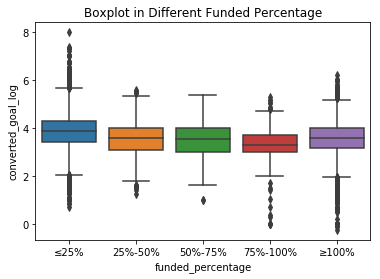

In [32]:
# EDA

## data construction
# subset
df_eda = df.loc[:, ['backers_count', 'country', 'fx_rate', 'goal', 'converted_pledged_amount', 'created_at', 'deadline']]
# calculate converted goal and time
df_eda['converted_goal'] = df_eda['goal'] * df_eda['fx_rate']
df_eda['duration'] = (df_eda['deadline'] - df_eda['created_at'])/86400
# get logarithm of predictors
    ## replace 0 by 1 in order to avoid divided by 0
df_eda['backers_count'] = df_eda['backers_count'].replace(0, 1)
df_eda['backers_count_log'] = np.log10(df_eda['backers_count'])
df_eda['converted_pledged_amount'] = df_eda['converted_pledged_amount'].replace(0, 1)
df_eda['converted_pledged_amount_log'] = np.log10(df_eda['converted_pledged_amount'])
df_eda['converted_goal_log'] = np.log10(df_eda['converted_goal'])
df_eda['duration_log'] = np.log10(df_eda['duration'])
# drop useless columns
df_eda = df_eda.drop(['fx_rate', 'goal', 'created_at', 'deadline'], axis = 1)
# review sorted dataset
#df_eda.sort_values(by = 'converted_pledged_amount', ascending = False).head(3)

## visualization
# histogram and scatter plot
#ax = sns.pairplot(df_eda[['converted_goal_log', 'duration_log', 'country']],
                  #hue = 'country', plot_kws={"s": 10})
#plt.show();

# pairplot
ax = sns.jointplot(x = 'duration_log', y = 'converted_goal_log', data = df_eda, kind = 'kde')
plt.show();

# predictor correlation
sns.heatmap(df_eda[['backers_count', 'converted_pledged_amount', 'converted_goal', 'duration']].corr(), annot = True, cmap = 'Blues')
plt.title('Predictor Correlation Matrix')
plt.show();

# campaigns count in different funded percentage
df_eda['funded_percentage'] = df_eda['converted_pledged_amount']/df_eda['converted_goal']
#df_eda.describe()
df_eda['funded_percentage'] = pd.cut(df_eda['funded_percentage'], [0, 0.25, 0.5, 0.75, 1, 10000])
funded_pt = ['≤25%', '25%-50%', '50%-75%', '75%-100%', '≥100%']
ax = sns.countplot(x = df_eda['funded_percentage'], palette = 'Set3')
ax.set_xticklabels(funded_pt)
plt.title('Campaigns in Different Funded Percentage')
plt.show();

# boxplot
ax = sns.boxplot(x = 'funded_percentage', y = 'converted_goal_log', data = df_eda)
ax.set_xticklabels(funded_pt)
plt.title('Boxplot in Different Funded Percentage')
plt.show();

# POS
- Tokenize texts
- Perform pos_tagging
- Count the number of adjectives, adverbs, comparatives, superlatives, and past tense words in a text
- Calculate the occurrence of each kind of words in a text

In [31]:
# POS
import nltk
from nltk.probability import FreqDist

adj, comp, sup, adv, pst = [],[],[],[],[]
for text in df['descripton']:
    # calculate length of each document
    doc_len = len(text)
    # tokenize text
    tokens = nltk.word_tokenize(text)
    # pos_tagging
    tag = nltk.pos_tag(tokens)
    # count occurences of adj, comp, sup, adv, and pst
    jj, jjr, jjs, rb, vbd = [],[],[],[],[]
    for elem in tag:
        if elem[1] == 'JJ':
            jj.append(elem[0])
        if elem[1] == 'JJR':
            jjr.append(elem[0])
        if elem[1] == 'JJS':
            jjs.append(elem[0])
        if elem[1] == 'RB':
            rb.append(elem[0])
        if elem[1] == 'VBD':
            vbd.append(elem[0])
    jj_len, jjr_len, jjs_len, rb_len, vbd_len = (len(jj)/doc_len)*100, (len(jjr)/doc_len)*100,\
    (len(jjs)/doc_len)*100, (len(rb)/doc_len)*100, (len(vbd)/doc_len)*100
    adj.append(jj_len)
    comp.append(jjr_len)
    sup.append(jjs_len)
    adv.append(rb_len)
    pst.append(vbd_len)
#len(adj), len(comp), len(sup), len(adv), len(pst)
#df['adj'], df['comp'], df['sup'], df['adv'], df['pst'] = adj, comp, sup, adv, pst
pos = pd.DataFrame(list(zip(adj, comp, sup, adv, pst)), columns = ['adj', 'comp', 'sup', 'adv', 'pst'])
#pos.to_csv("C:/Users/Administrator/Kickstarter/pos.csv", index = False)
pos.shape
pos.head()
# POS performance
pos['state'] = df['state']
pos.groupby('state').mean()

(52651, 5)

,adj,comp,sup,adv,pst
0,0.304878,0.000000,0.0,0.609756,0.152439
1,1.101495,0.039339,0.0,0.629426,0.118017
2,1.646091,0.000000,0.0,0.000000,0.411523
3,0.387597,0.000000,0.0,0.000000,0.387597
4,1.779359,0.088968,0.0,0.533808,0.444840


,adj,comp,sup,adv,pst
state,,,,,
failed,1.253343,0.061268,0.034309,0.651803,0.217234
successful,1.260414,0.062489,0.034202,0.629779,0.224189


# LIWC Program Analysis
- Read analysis results and look through the columns
- Select most representative features from the results

In [10]:
# more texual features from LIWC
liwc = pd.read_csv("C:/Users/Administrator/Kickstarter/description_liwc.csv")
liwc.shape
liwc.columns
liwc.head(3)
liwc_a = liwc.loc[:,[ 'Analytic', 'Clout', 'Authentic', 'Tone']]
liwc_a.head(3)
liwc_a.shape
#liwc_a.to_csv("C:/Users/Administrator/Kickstarter/features_liwc.csv", index = False)

(52651, 95)

Index(['A', 'B', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS',
       'Sixltr', 'Dic', 'function', 'pronoun', 'ppron', 'i', 'we', 'you',
       'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb',
       'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number',
       'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social',
       'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause',
       'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear',
       'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives',
       'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast',
       'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time',
       'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal',
       'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'AllPunc', 'Period',
       'Comma', 'Colon', 'SemiC', 'QMark', 'Exclam', 'Dash', 'Quote',
       'Apostro', 'Parenth', 'OtherP'

,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,3,The Traveled Journalist Guild provides a forum...,115,84.85,97.19,43.37,86.20,23.00,23.48,86.96,...,0.87,1.74,0.00,1.74,0.0,0.00,3.48,0.00,0.00,0.00
1,21,So many people aim to make a name for themselv...,465,82.69,32.59,60.40,90.06,20.22,19.78,90.32,...,7.74,0.22,0.22,0.22,0.0,1.51,1.29,1.29,0.86,0.22
2,27,"Creating a Fan made Naruto, It will be Awesome...",50,88.07,57.92,20.24,25.77,16.67,8.00,88.00,...,2.00,0.00,0.00,0.00,6.0,0.00,0.00,0.00,0.00,0.00


,Analytic,Clout,Authentic,Tone
0,84.85,97.19,43.37,86.20
1,82.69,32.59,60.40,90.06
2,88.07,57.92,20.24,25.77


(52651, 4)

# LDA Results Interpretation (Group Significance Part)
- Group campaigns by their state and calculate the average significance of each topic in each group
- According to the results, the first three topics show significant differences between successful and failed group

In [12]:
tm = pd.read_csv("C:/Users/Administrator/Kickstarter/docTopDist.csv")
tm_eda = pd.concat([df['state'], tm], axis = 1)
tm_eda.head()
tm_eda.groupby('state').mean()

,state,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,group_11,group_12
0,failed,0.087268,0.612316,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.283533,0.0
1,failed,0.000000,0.581331,0.0,0.020626,0.0,0.0,0.0,0.056090,0.0,0.0,0.334355,0.0
2,failed,0.010578,0.574822,0.0,0.288058,0.0,0.0,0.0,0.095511,0.0,0.0,0.000000,0.0
3,failed,0.000000,0.365814,0.0,0.034257,0.0,0.0,0.0,0.463608,0.0,0.0,0.107556,0.0
4,failed,0.000000,0.042126,0.0,0.000000,0.0,0.0,0.0,0.018329,0.0,0.0,0.931119,0.0


,group_1,group_2,group_3,group_4,group_5,group_6,group_7,group_8,group_9,group_10,group_11,group_12
state,,,,,,,,,,,,
failed,0.134669,0.242370,0.017947,0.108971,0.053565,0.082770,0.046290,0.071689,0.055915,0.010133,0.120236,0.045287
successful,0.035699,0.089656,0.080857,0.144813,0.063324,0.064259,0.062823,0.085421,0.138746,0.006140,0.154181,0.064954
